In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import cftime
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios

In [2]:
# Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=8)
#cluster.adapt(minimum=2, maximum=16)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.145:35239,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
ls ../tropical_pacific_carbon_export_code/processed/flux

avg_npp_rg_cafe.nc    chl.nc                       npp.nc
avg_npp_rg_cbpm.nc    fratios.nc                   pco2grams.nc
avg_npp_rg_eppley.nc  JMA_mooring_co2_flux.nc      tpca.nc
avg_npp_rg_vgpm.nc    landsch_mooring_co2_flux.nc  zeu.nc


In [4]:
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20))
#eqpac.time
eqpac=eqpac.sel(ensemble=25)

In [5]:
ls ../external_data/chl/TPCA/modis

tpca_seawifs_2002.nc  tpca_seawifs_2008.nc  tpca_seawifs_2014.nc
tpca_seawifs_2003.nc  tpca_seawifs_2009.nc  tpca_seawifs_2015.nc
tpca_seawifs_2004.nc  tpca_seawifs_2010.nc  tpca_seawifs_2016.nc
tpca_seawifs_2005.nc  tpca_seawifs_2011.nc  tpca_seawifs_2017.nc
tpca_seawifs_2006.nc  tpca_seawifs_2012.nc  tpca_seawifs_2018.nc
tpca_seawifs_2007.nc  tpca_seawifs_2013.nc  tpca_seawifs_2019.nc


In [6]:
modis_tpca=xr.open_mfdataset('../external_data/chl/TPCA/modis/*nc')

In [7]:
modis_tpca

<xarray.Dataset>
Dimensions:   (time: 6226, lon: 2040, lat: 240)
Coordinates:
  * time      (time) datetime64[ns] 2002-07-04 2002-07-05 ... 2019-07-27
  * lon       (lon) float32 120.0 120.1 120.2 120.3 ... 289.7 289.8 289.9 290.0
  * lat       (lat) float32 9.958 9.875 9.792 9.708 ... -9.792 -9.875 -9.958
Data variables:
    chl_tpca  (time, lat, lon) float32 dask.array<chunksize=(174, 240, 2040), meta=np.ndarray>
Attributes: (12/25)
    history:              TPCA applied to http://oceandata.sci.gsfc.nasa.gov
    institution:          University of Tasmania - IMAS
    Conventions:          CF-1.7, ACDD-1.3
    creator_name:         Nicholas Pittman
    creator_email:        Nic.Pittman@utas.edu.au
    title:                Tropical Pacific Chlorophyll Algorithm (TPCA): Repr...
    ...                   ...
    id:                   http://dx.doi.org/10.25914/5dccbd3b64bdc
    references:           Pittman, Nic, 2019: Tropical Pacific Chlorophyll Al...
    geospatial_lon_min:   150.0
    geospatial_lon_max:   -90.0
    source:               TPCA algorithm: https://github.com/nicpittman/TPCA_...
    date_created:         2019-08-01

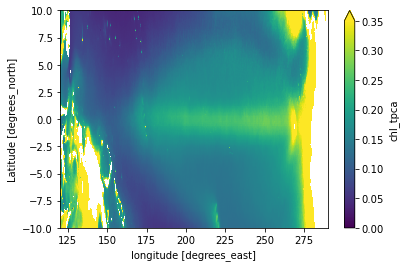

In [8]:
modis_tpca.chl_tpca.mean(dim='time').plot(vmin=0,vmax=0.35)

In [9]:
#modis_tpca.sel(time=slice(np.datetime64('2010-01-01'),np.datetime64('2018-12-31'))).mean(dim='time').chl_tpca.plot(vmin=-0,vmax=1)
#mg/chl/m3

In [10]:
#eqpac.surface_phy.sel(time=slice(cftime.DatetimeJulian(2010, 1, 1),cftime.DatetimeJulian(2018, 12, 31))).mean(dim='time').plot(vmin=0,vmax=1)
#mmol/M3?

In [11]:
#eqpac.pprod_.sel(time=slice(cftime.DatetimeJulian(2010, 1, 1),cftime.DatetimeJulian(2018, 12, 31))).mean(dim='time').plot(vmin=0,vmax=1)
#mmol/M3?

In [12]:
#eqpac.export_prod #mmolN/m^2/s
# Whereas the f-ratios 

In [13]:
# CAFE650 UNITS

#export_prod	mmolN/m^2/s
#pprod_gross	mmolN/m^3/s
#pprod_gross_2d	mmolN/m^2/s
#surface_phy	mmol/m^3

In [14]:
cafe_phy=eqpac.surface_phy
cafe_export=eqpac.export_prod
cafe_npp=eqpac.pprod_gross_2d

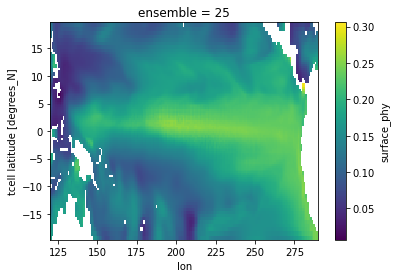

In [15]:
((cafe_phy.sel(time=slice(cftime.DatetimeJulian(2000,1,1),cftime.DatetimeJulian(2000,12,1)))*6.625*12)/100).mean(dim='time').plot()

In [16]:
#sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.eqpac.nc')
sst=xr.open_dataset('../processed_data/rey_eqpac_sst_rg.nc').__xarray_dataarray_variable__
npp=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_cafe.nc').avg_npp
npp_vgpm=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_vgpm.nc').avg_npp
npp_cbpm=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_cbpm.nc').avg_npp
npp_eppley=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_eppley.nc').avg_npp
chl=xr.open_dataset('../processed_data/obs/TPCA_month_regrid.nc').__xarray_dataarray_variable__
chl_modis=xr.open_dataset('../processed_data/obs/TPCA_modis_month_regrid.nc').__xarray_dataarray_variable__

In [17]:
tpca=xr.open_dataset('../processed_data/obs/TPCA_month_regrid.nc').__xarray_dataarray_variable__#.mean(dim='time').plot(vmin=0,vmax=0.3)

In [18]:
tpca_sw=xr.open_dataset('../processed_data/obs/TPCA_sw_month_regrid.nc').__xarray_dataarray_variable__
tpca_mod=xr.open_dataset('../processed_data/obs/TPCA_modis_month_regrid.nc').__xarray_dataarray_variable__

In [19]:
# NPP Conversions: 6.625*12*86400/1000,

In [20]:
import calendar
def JulianDate_to_MMDDYYY(y,jd):
        """Given a year and julian date, returns an np.datetime64 of the day"""
        month = 1
        while jd - calendar.monthrange(y,month)[1] > 0 and month <= 12:
            jd = jd - calendar.monthrange(y,month)[1]
            month = month + 1
           
        jd=str(jd).zfill(2) #turn into the form 01 02 03 10 etc
        month=str(month).zfill(2)    
        
        return str(y)+'-'+month+'-'+jd
    
def add_date(ds):
        jday=int(ds.attrs['id'][5:8])
        yr=int(ds.attrs['id'][1:5])
        
        #ds.coords['JulDay'] = jday
        date=JulianDate_to_MMDDYYY(yr,jday)
        ds.coords['time'] =  np.datetime64(date)
        return ds

In [21]:
#NASA CHL
nasa_sw_chlora=xr.open_mfdataset('../external_data/chlor_aMO/seawifs/*nc',concat_dim='time',combine='nested',preprocess=add_date).sortby('time')
nasa_sw_chlora=nasa_sw_chlora.assign_coords(lon=(nasa_sw_chlora.lon % 360)).roll(lon=(nasa_sw_chlora.dims['lon'] // 2),roll_coords=True)
nasa_sw_chlora=nasa_sw_chlora.chlor_a#drop('palette')
nasa_sw_chlora=nasa_sw_chlora.sel(lon=slice(120,290),lat=slice(20,-20)).sortby('lon')

In [22]:
## Uhh MODIS has weird lats and longs, setting it to the chl dataset seems to work though.
nasa_modis_chlora=xr.open_mfdataset('../external_data/chlor_aMO/modis/*nc',concat_dim='time',combine='nested',preprocess=add_date).sortby('time')
nasa_modis_chlora=nasa_modis_chlora.assign_coords(lon=(nasa_modis_chlora.lon % 360)).roll(lon=(nasa_modis_chlora.dims['lon']//2), roll_coords=True)
nasa_modis_chlora=nasa_modis_chlora.sortby('lon')
nasa_modis_chlora=nasa_modis_chlora.chlor_a.drop_duplicates(dim='lon')
nasa_modis_chlora=nasa_modis_chlora.sel(lat=nasa_sw_chlora.lat.values,method='nearest')
nasa_modis_chlora=nasa_modis_chlora.sel(lon=nasa_sw_chlora.lon.values,method='nearest')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...   

In [23]:
nasa_modis_chlora

<xarray.DataArray 'chlor_a' (time: 231, lat: 480, lon: 2040)>
dask.array<getitem, shape=(231, 480, 2040), dtype=float32, chunksize=(1, 480, 2040), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 19.96 19.87 19.79 19.71 ... -19.79 -19.88 -19.96
  * lon      (lon) float64 120.0 120.1 120.2 120.3 ... 289.7 289.8 289.9 290.0
  * time     (time) datetime64[ns] 2002-07-01 2002-08-01 ... 2021-09-01
Attributes:
    long_name:      Chlorophyll Concentration, OCI Algorithm
    units:          mg m^-3
    standard_name:  mass_concentration_chlorophyll_concentration_in_sea_water
    valid_min:      0.001
    valid_max:      100.0
    reference:      Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a alg...
    keywords:       EARTH SCIENCE > OCEANS > OCEAN CHEMISTRY > CHLOROPHYLL
    display_scale:  log
    display_min:    0.01
    display_max:    20.0

In [24]:
nasa_sw_chlora

<xarray.Dataset>
Dimensions:  (time: 155, lat: 480, lon: 2040)
Coordinates:
  * lat      (lat) float32 19.96 19.87 19.79 19.71 ... -19.79 -19.88 -19.96
  * lon      (lon) float32 120.0 120.1 120.2 120.3 ... 289.7 289.8 289.9 290.0
  * time     (time) datetime64[ns] 1997-09-01 1997-10-01 ... 2010-12-01
Data variables:
    chlor_a  (time, lat, lon) float32 dask.array<chunksize=(1, 480, 2040), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      S19972441997273.L3m_MO_CHL_chlor_a_9km.nc
    instrument:                        SeaWiFS
    title:                             SeaWiFS Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Orbview-2
    temporal_range:                    26-day
    ...                                ...
    identifier_product_doi:            10.5067/ORBVIEW-2/SEAWIFS/L3M/CHL/2018
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3767293
    data_minimum:                      0.009950089
    data_maximum:                      93.69129

In [25]:
# F-ratio / export algo calcs
chl=tpca
#CALC DIFFERENT f-ratio ALGOS. Need to multiply these ratios with the new prodution rate to get export flux.
zeu1= 34*chl**-0.39#lee 2007
zeu2=38*chl**-0.428#Morel 1989
pe_dunne=-0.0101*sst+0.0582*np.log(npp/zeu1)+0.419
pe_dunne2=-0.0101*sst+0.0582*np.log(npp/zeu2)+0.419
pe_dunne3=0.0081*sst+0.0668*np.log(chl/zeu2)+0.426
f_ratio=(0.62-(0.02*sst))
th_e_ratio=(0.23*np.exp(-0.08*sst))
laws2011a=((0.5857-0.0165*sst)*npp)/(51.7+npp)
laws2011b=0.04756*(0.78-((0.43*sst)/30))*npp**0.307 #avgnpp

trim=convert_trim_fratios(trim_path='../external_data/fratios/SIMPLE_TRIM_output.nc',
                         regrid_path='../processed_data/rey_eqpac_sst_rg.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/core/computation.py:742: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


8.937507092919455


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [26]:
export_laws2011a=npp*laws2011a
export_dunne=npp*pe_dunne
export_f=npp*f_ratio
export_trim=npp*trim

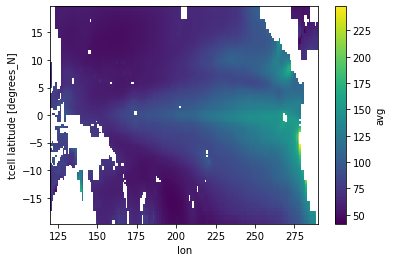

In [27]:
#CHECK
#export_trim.avg.mean(dim='time').plot()
#export_laws2011a.mean(dim='time').plot()
#laws2011a.mean(dim='time').plot()
#laws2011b.mean(dim='time').plot()

In [31]:
#cafe_npp=cafe_npp*6.625*12*86400/1000
#cafe_phy=cafe_phy*6.625*12*86400/1000
#cafe_export=cafe_export*6.625*12*86400/1000

In [32]:
#cafe_npp
#npp #cafe
#npp_cbpm
#npp_vgpm
#npp_eppley

#chl
#cafe_phy


#cafe_export
#export_laws2011a
#export_dunne
#export_f
#export_trim



#pprod_gross_2d	mmolN/m^2/s
#phy		mmol/m^3
#export_prod	mmolN/m^2/s

In [33]:
cluster.scale(cores=12)

In [34]:
cluster

0


/local/v45/np1383/tmp/ipykernel_3378570/1367474711.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_phy_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


1


/local/v45/np1383/tmp/ipykernel_3378570/1367474711.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_phy_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


2


/local/v45/np1383/tmp/ipykernel_3378570/1367474711.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_phy_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


3


/local/v45/np1383/tmp/ipykernel_3378570/1367474711.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_phy_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


4


/local/v45/np1383/tmp/ipykernel_3378570/1367474711.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_phy_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


5


/local/v45/np1383/tmp/ipykernel_3378570/1367474711.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_phy_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


6


/local/v45/np1383/tmp/ipykernel_3378570/1367474711.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_phy_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


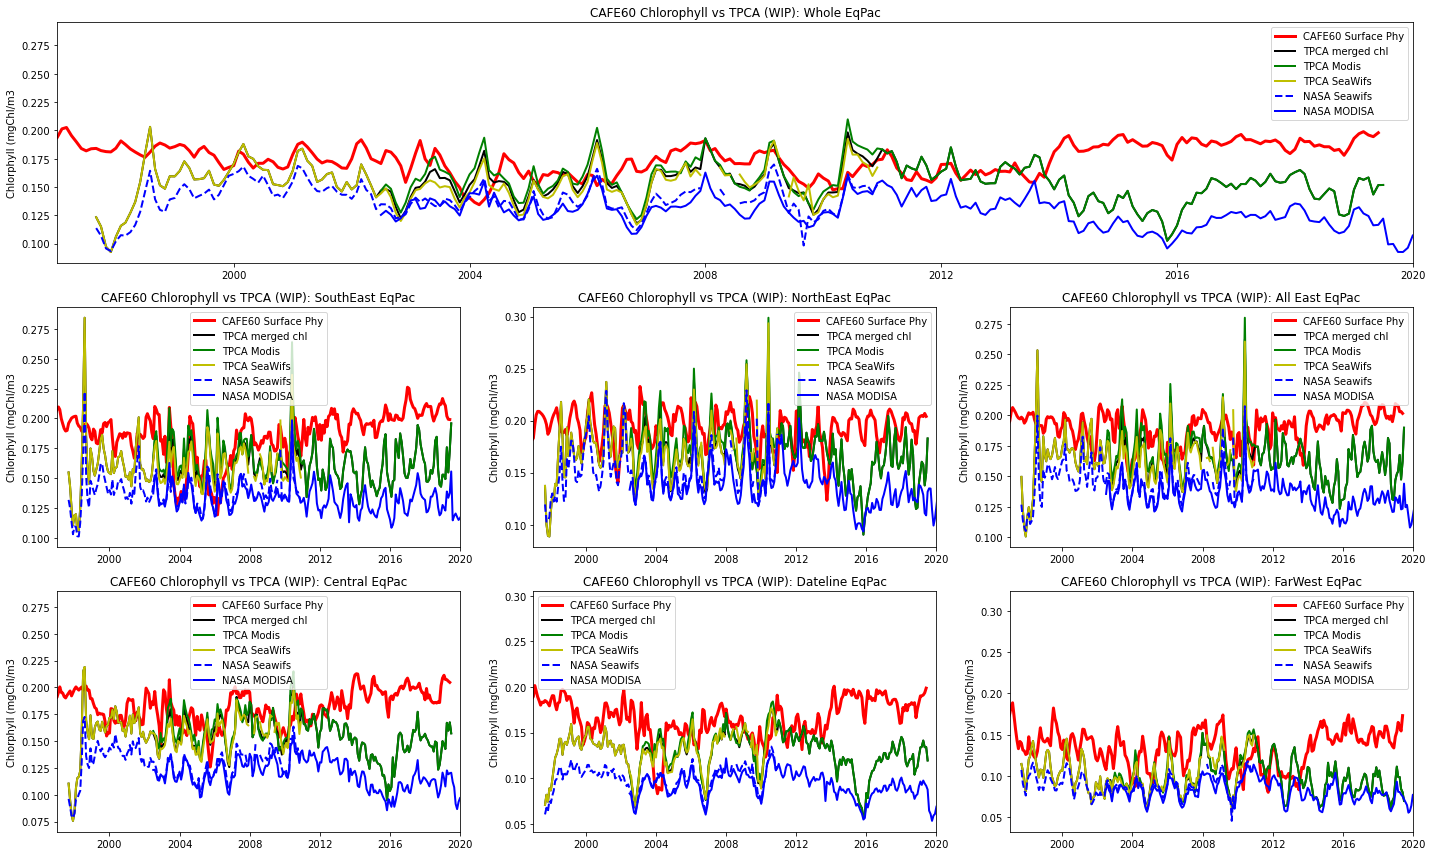

In [35]:
#Ok how does this error look through time for different parts of the Pacific.
labels=['Whole EqPac',
       'SouthEast EqPac',
       'NorthEast EqPac',
        'All East EqPac',
        'Central EqPac',
        'Dateline EqPac',
        'FarWest EqPac']

locs=[[-15,15,150,275],
      [-15,0,225,250],
      [0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,175,200],
      [-15,15,150,175]]
      
plt.figure(figsize=(20,12))

all_err=[]
for i,latlon in enumerate(locs):
    print(i)
    
    
    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
        
        
    cafe_phy_ts=((cafe_phy).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']))
    chl_ts=chl.where(chl != 0).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    chl_modis_ts=chl_modis.where(chl_modis != 0).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    chl_sw_ts=tpca_sw.where(tpca_sw != 0).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    
    nasa_mod_ts=nasa_modis_chlora.sel(lat=slice(latlon[1],latlon[0]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    nasa_sw_ts=nasa_sw_chlora.sel(lat=slice(latlon[1],latlon[0]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    
    
    cafe60_time=np.array(cafe_phy_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
    
    plt.plot(cafe60_time[:-6],(cafe_phy_ts[:-6]*(6.625*12/100)),c='r',linewidth=3) # s[:-6] to remove the last 6 months of bad data in the CAFE60 phy estimates.
    plt.plot(chl_ts.time,chl_ts,c='k',linewidth=2)
    plt.plot(chl_modis_ts.time,chl_modis_ts,c='g',linewidth=2)
    plt.plot(chl_sw_ts.time,chl_sw_ts,c='y',linewidth=2)
    
    
    plt.plot(nasa_sw_ts.time,nasa_sw_ts.chlor_a,c='b',linestyle='--',linewidth=2)
    plt.plot(nasa_mod_ts.time,nasa_mod_ts,c='b',linewidth=2)
    
    plt.xlim([np.datetime64('1997-01-01'),np.datetime64('2020-01-01')])
    
    
    ax.legend(['CAFE60 Surface Phy','TPCA merged chl','TPCA Modis','TPCA SeaWifs','NASA Seawifs','NASA MODISA'])
    ax.set_xlim([np.datetime64('1997-01-01'),np.datetime64('2020-01-01')])
    ax.set_ylabel('Chlorphyll (mgChl/m3')
    #ax.set_title('CO2 flux comparisons')
    ax.set_title('CAFE60 Chlorophyll vs TPCA (WIP): '+labels[i])
    
plt.tight_layout()
plt.show()

#UNITS surface_phy=mmol/m^3
# output should me mg Chl M3

In [39]:
plt.plot(nasa_sw_ts.time,nasa_sw_ts.chlor_a,c='b',linestyle='--',linewidth=2)
plt.plot(nasa_mod_ts.time,nasa_mod_ts,c='b',linewidth=2)    

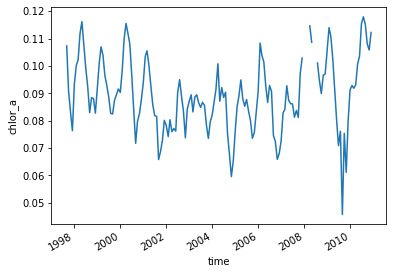

In [47]:
nasa_sw_chlora.chlor_a.sel(lat=slice(latlon[1],latlon[0]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']).plot()

In [40]:
nasa_mod_ts

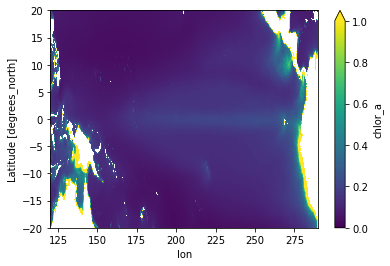

In [43]:
nasa_modis_chlora.mean(dim='time').plot(vmin=0,vmax=1)

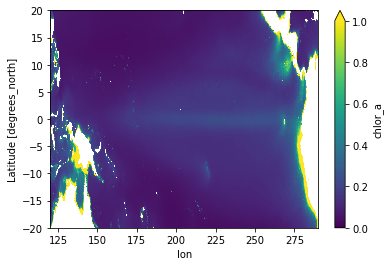

In [45]:
nasa_sw_chlora.mean(dim='time').chlor_a.plot(vmin=0,vmax=1)

In [ ]:
#TEST  phy
latlon= [-15,0,225,250]
cafe_phy_ts=((cafe_phy).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']))
chl_ts=chl.where(chl != 0).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
chl_modis_ts=chl_modis.where(chl_modis != 0).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
chl_sw_ts=tpca_sw.where(tpca_sw != 0).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])

#cafe_npp_ts=cafe_npp.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])

cafe60_time=np.array(cafe_npp_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')

plt.plot(cafe60_time,(cafe_phy_ts*(6.625*12/100)),c='r',linewidth=2)
plt.plot(chl_ts.time,chl_ts,c='k',linewidth=2)
plt.plot(chl_modis_ts.time,chl_modis_ts,c='g',linewidth=2)
plt.plot(chl_sw_ts.time,chl_sw_ts,c='y',linewidth=2)

In [ ]:
#Ok how does this error look through time for different parts of the Pacific.
# NPP
labels=['Whole EqPac',
       'SouthEast EqPac',
       'NorthEast EqPac',
        'All East EqPac',
        'Central EqPac',
        'Dateline EqPac',
        'FarWest EqPac']

locs=[[-15,15,150,275],
      [-15,0,225,250],
      [0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,175,200],
      [-15,15,150,175]]
      
plt.figure(figsize=(20,12))

all_err=[]
for i,latlon in enumerate(locs):
    print(i)
    
    
    
    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
        

    npp_ts=npp.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    npp_cbpm_ts=npp_cbpm.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    npp_vgpm_ts=npp_vgpm.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    npp_eppley_ts=npp_eppley.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    cafe_npp_ts=cafe_npp.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    cafe60_time=np.array(cafe_npp_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')

    
    plt.plot(cafe60_time,(cafe_npp_ts*6.625*12*86400),c='r',linewidth=2)
   
    #plt.plot(cafe60_time,(cafe_npp_ts*(6.625*12/100))*86400,c='r',linestyle='--',linewidth=2) ###*12*86400*10 OLD CONVERT
    #plt.plot(cafe60_time,(cafe_npp_ts/6.625*12*86400),c='r',linestyle='--',linewidth=2)#
    plt.plot(npp_ts.time,npp_ts,c='k',linewidth=2)
    plt.plot(npp_cbpm_ts.time,npp_cbpm_ts,c='g',linewidth=2)
    plt.plot(npp_vgpm_ts.time,npp_vgpm_ts,c='y',linewidth=2)
    plt.plot(npp_eppley_ts.time,npp_eppley_ts,c='b',linewidth=2)
    
    #'CAFE60 NPP conversion v2 *(6.625*12/100))*86400',
    plt.legend(['CAFE60 NPP *6.625*12*86400','CAFE Algo NPP','CbPM NPP','VGPM NPP','Eppley VGPM'])
    ax.set_xlim([np.datetime64('1997-01-01'),np.datetime64('2020-01-01')])
    
    ax.set_ylabel('Net/Gross Primary Production (mgC/m2/day')
    #ax.set_title('CO2 flux comparisons')
    ax.set_title('CAFE60 NPP: '+labels[i])
    
plt.tight_layout()
plt.show()

#UNITS surface_phy=mmol/m^3
# output should me mg Chl M3

0


/local/v45/np1383/tmp/ipykernel_2123728/4111914312.py:49: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_export_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


1


/local/v45/np1383/tmp/ipykernel_2123728/4111914312.py:49: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_export_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


2


/local/v45/np1383/tmp/ipykernel_2123728/4111914312.py:49: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_export_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


3


/local/v45/np1383/tmp/ipykernel_2123728/4111914312.py:49: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_export_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


4


/local/v45/np1383/tmp/ipykernel_2123728/4111914312.py:49: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_export_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


5


/local/v45/np1383/tmp/ipykernel_2123728/4111914312.py:49: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_export_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


6


/local/v45/np1383/tmp/ipykernel_2123728/4111914312.py:49: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cafe60_time=np.array(cafe_export_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


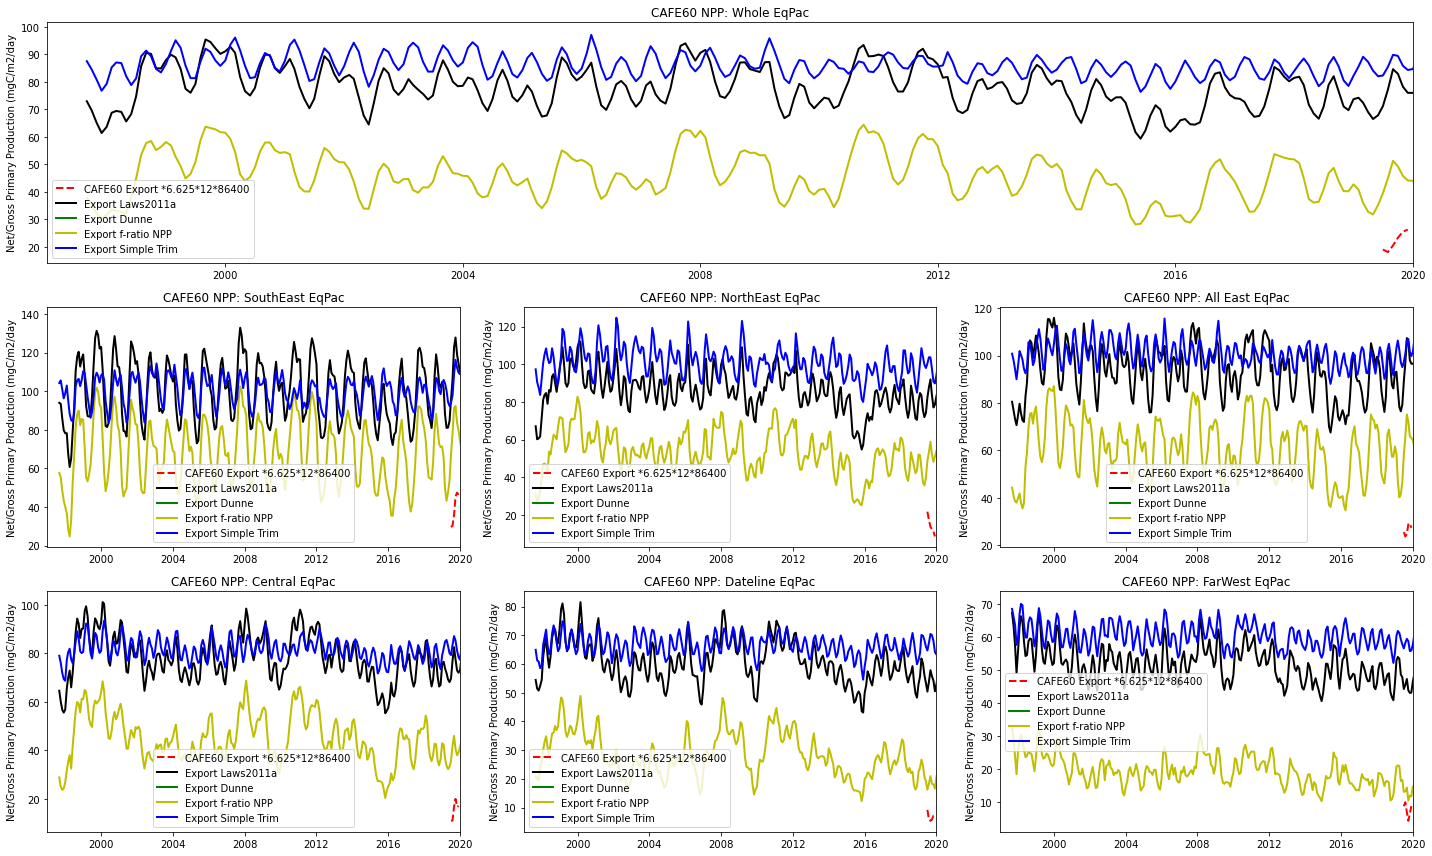

In [34]:
#Ok how does this error look through time for different parts of the Pacific.

# EXPORT
labels=['Whole EqPac',
       'SouthEast EqPac',
       'NorthEast EqPac',
        'All East EqPac',
        'Central EqPac',
        'Dateline EqPac',
        'FarWest EqPac']

locs=[[-15,15,150,275],
      [-15,0,225,250],
      [0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,175,200],
      [-15,15,150,175]]
      
plt.figure(figsize=(20,12))

all_err=[]
for i,latlon in enumerate(locs):
    print(i)
    
    
    
    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
        

    cafe_export
    export_laws2011a
    export_dunne
    export_f
    export_trim
    
    
    
    
    cafe_export_ts=cafe_export.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    export_laws2011a_ts=export_laws2011a.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    export_dunne_ts=export_dunne.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    export_f_ts=export_f.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    export_trim_ts=export_trim.avg.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])

    cafe60_time=np.array(cafe_export_ts.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')

    

    plt.plot(cafe60_time,(cafe_export_ts*6.625*12*86400),c='r',linestyle='--',linewidth=2) ###*12*86400*10 OLD CONVERT
    plt.plot(export_laws2011a_ts.time,export_laws2011a_ts,c='k',linewidth=2)
    plt.plot(export_dunne_ts.time,export_dunne_ts,c='g',linewidth=2)
    plt.plot(export_f_ts.time,export_f_ts,c='y',linewidth=2)
    plt.plot(export_trim_ts.time,export_trim_ts,c='b',linewidth=2)
    
    plt.legend(['CAFE60 Export *6.625*12*86400','Export Laws2011a','Export Dunne','Export f-ratio NPP','Export Simple Trim'])
    ax.set_xlim([np.datetime64('1997-01-01'),np.datetime64('2020-01-01')])
    
    ax.set_ylabel('Net/Gross Primary Production (mgC/m2/day')
    #ax.set_title('CO2 flux comparisons')
    ax.set_title('CAFE60 NPP: '+labels[i])
    
plt.tight_layout()
plt.show()

#UNITS surface_phy=mmol/m^3
# output should me mg Chl M3

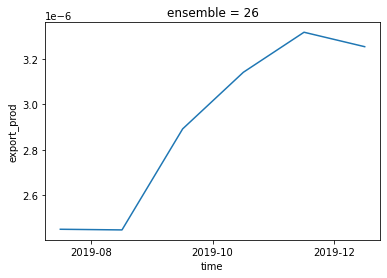

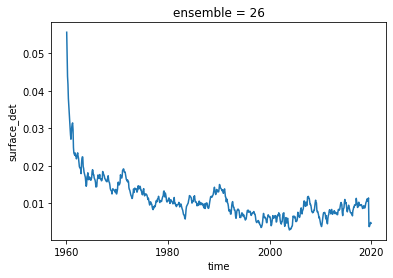

In [33]:

# TEST EXPORT ??? ONLY AT END TS?


bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20))
#eqpac.time
eqpac=eqpac.sel(ensemble=26)


export=eqpac.export_prod
export.mean(dim=['lat','lon']).plot()
plt.show()

detritus=eqpac.surface_det
detritus.mean(dim=['lat','lon']).plot()
plt.show()

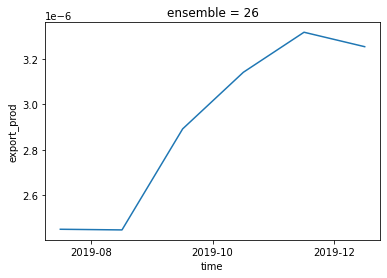

In [32]:
# TEST EXPORT ??? ONLY AT END TS?


bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20))
#eqpac.time
eqpac=eqpac.sel(ensemble=26)

export=eqpac.export_prod
export.mean(dim=['lat','lon']).plot()

In [ ]:
#export_laws2011a=npp*laws2011a
#export_dunne=npp*pe_dunne
#export_f=npp*f_ratio
#export_trim=npp*trim

In [ ]:
    
    #Conversion  #mmol/s to mol/s to mol/day to g/day and also invert for sea-air flux
    cafe_co2_std_reg=(cafe_co2_all_g).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    cafe_co2_mean_reg=(cafe_co2_all_g).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    
    cafe_co2_nat_std_reg=(cafe_co2_nat_g).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    cafe_co2_nat_mean_reg=(cafe_co2_nat_g).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    
    
    land_co2_std_reg=((land_co2.fgco2_smoothed)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3]),time=slice(np.datetime64('1982-01-01'),np.datetime64('2020-01-01'))).std(dim=['lat','lon'])
    land_co2_mean_reg=((land_co2.fgco2_smoothed)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3]),time=slice(np.datetime64('1982-01-01'),np.datetime64('2020-01-01'))).mean(dim=['lat','lon'])
    
    #rodenbeck_co2_f=rodenbeck_co2/(10**15/365)
    rodenbeck_co2_std_reg=((rodenbeck_co2.co2flux_ocean)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])#/2
    rodenbeck_co2_mean_reg=((rodenbeck_co2.co2flux_ocean)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])#/2
    
    best_co2_ensemble=cafe_co2_mean_reg.stf10.sel(ensemble=best_ensemble_member)
    best_co2_nat_ensemble=cafe_co2_nat_mean_reg.stf07.sel(ensemble=best_ensemble_member)
    
    print('cafe Co2 flux: '+ str(best_co2_ensemble.mean(dim=['time']).values))
    print('cafe Co2 Natural flux: '+ str(best_co2_nat_ensemble.mean(dim=['time']).values))
    
    print('land co2 flux: '+str(land_co2_mean_reg.mean(dim=['time']).values))
    print('Rodenbeck co2 flux: '+str(rodenbeck_co2_mean_reg.mean(dim=['time']).values))
    
    #region_co2_path='../processed_data/co2_region_ens/co2_regional_ens_'+str(labels[i])+'.nc'
    #cafe_co2_mean_reg.to_netcdf(region_co2_path)
    
    err=cafe_co2_mean_reg.std(dim='ensemble').load()
    m=cafe_co2_mean_reg.mean(dim='ensemble').load()
    
   
    
    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
    ax.plot(m.time,m.stf10)
    ax.fill_between(err.time.values,m.stf10+(err*1).stf10,m.stf10-(err*1).stf10,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.stf10+(err*2).stf10,m.stf10-(err*2).stf10,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.stf10+(err*3).stf10,m.stf10-(err*3).stf10,alpha=0.2,color='blue')

    ax.plot(land_co2_mean_reg.time,land_co2_mean_reg,c='k',linewidth=2)
    ax.plot(rodenbeck_co2_mean_reg.time,rodenbeck_co2_mean_reg,c='b',linewidth=2)
    
    # Plot the Seemingly most accurate CO2 flux ens member
    ax.plot(cafe_co2_mean_reg.time.values,best_co2_ensemble,c='r',linewidth=2)
    ax.plot(cafe_co2_nat_mean_reg.time.values,best_co2_nat_ensemble,c='g',linewidth=1)
    
    
    ax.legend(['CAFE60 Mean (1-3std)','Landschutzer','Rodenbeck','Best CO2 ensemble member','BestEns NaturalCO2'])
    ax.set_xlim([np.datetime64('1980-01-01'),np.datetime64('2020-01-01')])
    ax.set_ylabel('Air-Sea C Outgassing gC/m2/day')
    #ax.set_title('CO2 flux comparisons')
    ax.set_title('CAFE60 CO2 flux vs Landschutzer: '+labels[i])

    
    #Calculate biases
    
    #These biases might be backwards.
    perc_err=(((cafe_co2_mean_reg.stf10-land_co2_mean_reg)/land_co2_mean_reg)*100).mean(dim='time')
    bias=(cafe_co2_mean_reg.stf10-land_co2_mean_reg).mean(dim='time')
    mae=np.abs(cafe_co2_mean_reg.stf10-land_co2_mean_reg).mean(dim='time')
    print(labels[i]+' : '+str(perc_err.mean(dim='ensemble').values) + '% err')
    perc_err.name='percenterr'
    bias.name='bias'
    mae.name='mae'
    err_stats=xr.merge([perc_err,bias,mae],compat='override')
    err_stats['region']=i
    err_stats['region_name']=labels[i]
    all_err.append(err_stats)
    
regional_err=xr.concat(all_err,dim='region')

#Where do we want to save results??
#regional_err.to_netcdf('/scratch1/pit071/CO2_flux_error.nc')
plt.tight_layout()
plt.show()
print(regional_err)
regional_err.to_netcdf('../processed_data/err/regional_co2_err.nc')